# Imports

In [796]:
import numpy as np
import pandas as pd
import json
import gzip
import os
import datetime
from dateutil import parser
from tqdm import tqdm

SensorKit in [ISO 8601 format](https://en.wikipedia.org/wiki/ISO_8601)

So my understanding is that when we look at:

```
data['samples'][0]['timestamp']
>>> '2022-09-27T08:45:00-0400'
```

...we are getting the local time and also how many hours off it is from UTC (-4 hours in this case - so UTC is 4 hours **later**)


# Load Data

In [736]:
filepath = '../3_3_1_raw_data/testing/run1_check_adherence/RK.8D1DBFAD.DJWThesis_20221005-20221006/sensorkit-keyboard-metrics/iPhone/01801252-3a7e-4f5f-8b6d-49e8da3902f3/F166C0E0-82A6-45BD-A01E-FA5C1080B990/2022-10-03T223208-0700_2022-10-04T134032-0700.json.gz'

In [733]:
path = '../3_3_1_raw_data/testing/run1_check_adherence/'

In [737]:
with gzip.open(filepath, 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))

# SensorKit Data

## Device Usage

In [1177]:
#Create a DataFrame object
df = pd.DataFrame(
    columns = [
        'ParticipantIdentifier', 
        'datetime',
        'trial_date',
        'time',
        'duration', 
        'total_unlocks', 
        'total_unlock_duration',
        # device usage
        'app_usage_books',
        'app_usage_business',
        'app_usage_catalogs',
        'app_usage_developer_tools',
        'app_usage_education',
        'app_usage_entertainment',
        'app_usage_finance',
        'app_usage_food_and_drink',
        'app_usage_games',
        'app_usage_graphics_and_design',
        'app_usage_health_and_fitness',
        'app_usage_kids',
        'app_usage_lifestyle',
        'app_usage_medical',
        'app_usage_miscellaneous',
        'app_usage_music',
        'app_usage_navigation',
        'app_usage_news',
        'app_usage_newsstand',
        'app_usage_photo_and_video',
        'app_usage_productivity',
        'app_usage_reference',
        'app_usage_shopping',
        'app_usage_social_networking',
        'app_usage_sports',
        'app_usage_stickers',
        'app_usage_travel',
        'app_usage_utilities',
        'app_usage_weather',
        'web_usage_books',
        'web_usage_business',
        'web_usage_catalogs',
        'web_usage_developer_tools',
        'web_usage_education',
        'web_usage_entertainment',
        'web_usage_finance',
        'web_usage_food_and_drink',
        'web_usage_games',
        'web_usage_graphics_and_design',
        'web_usage_health_and_fitness',
        'web_usage_kids',
        'web_usage_lifestyle',
        'web_usage_medical',
        'web_usage_miscellaneous',
        'web_usage_music',
        'web_usage_navigation',
        'web_usage_news',
        'web_usage_newsstand',
        'web_usage_photo_and_video',
        'web_usage_productivity',
        'web_usage_reference',
        'web_usage_shopping',
        'web_usage_social_networking',
        'web_usage_sports',
        'web_usage_stickers',
        'web_usage_travel',
        'web_usage_utilities',
        'web_usage_weather'
    ]
)

In [1178]:
days = [i for i in os.listdir(path) if i.startswith('RK')]
for day in tqdm(days):
    files = os.listdir(path + day)
    sensors = [i for i in files if i.startswith('sensor')]
    for sensor in sensors:
        # select for sensor
        if sensor == 'sensorkit-device-usage':
            participants = [i for i in os.listdir(path+day+ '/' + sensor + '/iPhone') if not i.startswith('.')]
            for participant in participants: 
                ParticipantIdentifier = participant
                devices = [i for i in os.listdir(path+day+ '/' + sensor+ '/iPhone/' + participant) if not i.startswith('.')]
                for device in devices:
                    data_files = os.listdir(path+day + '/' + sensor+ '/iPhone/' + participant + '/' + device)
                    for subfile in data_files:
                        filepath = path+day+ '/' + sensor + '/iPhone/' + participant + '/' + device + '/' + subfile
                        if filepath.endswith('.gz'):
                            try:
                                with gzip.open(filepath, 'r') as fin:
                                    data = json.loads(fin.read().decode('utf-8'))
                                    
                                    rows = df.shape[0]
                                    for i in range(len(data['samples'])):
                                        # dynamically creating df: https://stackoverflow.com/questions/48030350/dynamically-add-rows-to-dataframe

                                        df.loc[rows + i, 'ParticipantIdentifier'] = ParticipantIdentifier 
                                        dt = parser.parse(data['samples'][i]['timestamp']) # str -> datetime of sample
                                        df.loc[rows + i, 'datetime'] = dt
                                        df.loc[rows + i, 'trial_date'] = (dt + datetime.timedelta(hours = -4)).date() # trial day associated with sample (4am is when the day flips)
                                        df.loc[rows + i, 'time'] = dt.time()
                                        df.loc[rows + i, 'duration'] = data['samples'][i]['sample']['duration']
                                        df.loc[rows + i, 'total_unlocks'] = data['samples'][i]['sample']['totalUnlocks']
                                        df.loc[rows + i, 'total_unlock_duration'] = data['samples'][i]['sample']['totalUnlockDuration']

                                        # web usage
                                        for j in range(len(data['samples'][i]['sample']['webUsageByCategory'])//2):
                                            web_use = data['samples'][i]['sample']['webUsageByCategory']
                                            # go through categories...
                                            if web_use[j] == 'SRDeviceUsageCategoryBooks':
                                                df.loc[rows + i, 'web_usage_books'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryBusiness':
                                                df.loc[rows + i, 'web_usage_business'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryCatalogs':
                                                df.loc[rows + i, 'web_usage_catalogs'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryDeveloperTools':
                                                df.loc[rows + i, 'web_usage_developer_tools'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryEducation':
                                                df.loc[rows + i, 'web_usage_education'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryEntertainment':
                                                df.loc[rows + i, 'web_usage_entertainment'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryFinance':
                                                df.loc[rows + i, 'web_usage_finance'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryFoodAndDrink':
                                                df.loc[rows + i, 'web_usage_food_and_drink'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryGames':
                                                df.loc[rows + i, 'web_usage_games'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryGraphicsAndDesign':
                                                df.loc[rows + i, 'web_usage_graphics_and_design'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryHealthAndFitness':
                                                df.loc[rows + i, 'web_usage_health_and_fitness'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryKids':
                                                df.loc[rows + i, 'web_usage_kids'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryLifestyle':
                                                df.loc[rows + i, 'web_usage_lifestyle'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryMedical':
                                                df.loc[rows + i, 'web_usage_medical'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryMiscellaneous':
                                                df.loc[rows + i, 'web_usage_utilities_miscellaneous'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryMusic':
                                                df.loc[rows + i, 'web_usage_music'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryNavigation':
                                                df.loc[rows + i, 'web_usage_navigation'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryNews':
                                                df.loc[rows + i, 'web_usage_news'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryNewsstand':
                                                df.loc[rows + i, 'web_usage_newsstand'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryPhotoAndVideo':
                                                df.loc[rows + i, 'web_usage_photo_and_video'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryProductivity':
                                                df.loc[rows + i, 'web_usage_productivity'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1])
                                            if web_use[j] == 'SRDeviceUsageCategoryReference':
                                                df.loc[rows + i, 'web_usage_reference'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1]) # sums up values in a list of dicts for given key
                                            if web_use[j] == 'SRDeviceUsageCategoryShopping':
                                                df.loc[rows + i, 'web_usage_shopping'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1]) # sums up values in a list of dicts for given key
                                            if web_use[j] == 'SRDeviceUsageCategorySocialNetworking':
                                                df.loc[rows + i, 'web_usage_social_networking'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1]) # sums up values in a list of dicts for given key
                                            if web_use[j] == 'SRDeviceUsageCategorySports':
                                                df.loc[rows + i, 'web_usage_sports'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1]) # sums up values in a list of dicts for given key
                                            if web_use[j] == 'SRDeviceUsageCategoryStickers':
                                                df.loc[rows + i, 'web_usage_stickers'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1]) # sums up values in a list of dicts for given key
                                            if web_use[j] == 'SRDeviceUsageCategoryTravel':
                                                df.loc[rows + i, 'web_usage_travel'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1]) # sums up values in a list of dicts for given key
                                            if web_use[j] == 'SRDeviceUsageCategoryUtilities':
                                                df.loc[rows + i, 'web_usage_utilities'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1]) # sums up values in a list of dicts for given key
                                            if web_use[j] == 'SRDeviceUsageCategoryWeather':
                                                df.loc[rows + i, 'web_usage_weather'] = sum(d.get('totalUsageTime', 0) for d in web_use[j+1]) # sums up values in a list of dicts for given key

                                        # app usage
                                        for j in range(len(data['samples'][i]['sample']['applicationUsageByCategory'])//2):
                                            app_use = data['samples'][i]['sample']['applicationUsageByCategory']
                                            # go through categories
                                            if app_use[j] == 'SRDeviceUsageCategoryBooks':
                                                df.loc[rows + i, 'app_usage_books'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryBusiness':
                                                df.loc[rows + i, 'app_usage_business'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryCatalogs':
                                                df.loc[rows + i, 'app_usage_catalogs'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryDeveloperTools':
                                                df.loc[rows + i, 'app_usage_developer_tools'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryEducation':
                                                df.loc[rows + i, 'app_usage_education'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryEntertainment':
                                                df.loc[rows + i, 'app_usage_entertainment'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryFinance':
                                                df.loc[rows + i, 'app_usage_finance'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryFoodAndDrink':
                                                df.loc[rows + i, 'app_usage_food_and_drink'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryGames':
                                                df.loc[rows + i, 'app_usage_games'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryGraphicsAndDesign':
                                                df.loc[rows + i, 'app_usage_graphics_and_design'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryHealthAndFitness':
                                                df.loc[rows + i, 'app_usage_health_and_fitness'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryKids':
                                                df.loc[rows + i, 'app_usage_kids'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryLifestyle':
                                                df.loc[rows + i, 'app_usage_lifestyle'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryMedical':
                                                df.loc[rows + i, 'app_usage_medical'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryMiscellaneous':
                                                df.loc[rows + i, 'app_usage_miscellaneous'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryMusic':
                                                df.loc[rows + i, 'app_usage_music'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryNavigation':
                                                df.loc[rows + i, 'app_usage_navigation'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryNews':
                                                df.loc[rows + i, 'app_usage_news'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryNewsstand':
                                                df.loc[rows + i, 'app_usage_newsstand'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryPhotoAndVideo':
                                                df.loc[rows + i, 'app_usage_photo_and_video'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryProductivity':
                                                df.loc[rows + i, 'app_usage_productivity'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryReference':
                                                df.loc[rows + i, 'app_usage_reference'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryShopping':
                                                df.loc[rows + i, 'app_usage_shopping'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategorySocialNetworking':
                                                df.loc[rows + i, 'app_usage_social_network'] = sum(d.get('usageTime', 0) for d in app_use[j+1])            
                                            if app_use[j] == 'SRDeviceUsageCategorySports':
                                                df.loc[rows + i, 'app_usage_sports'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryStickers':
                                                df.loc[rows + i, 'app_usage_stickers'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryTravel':
                                                df.loc[rows + i, 'app_usage_travel'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryUtilities':
                                                df.loc[rows + i, 'app_usage_utilities'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                            if app_use[j] == 'SRDeviceUsageCategoryWeather':
                                                df.loc[rows + i, 'app_usage_weather'] = sum(d.get('usageTime', 0) for d in app_use[j+1])
                                    
                            except (OSError, ValueError) as e:  
                                pass

# save to csv
df.to_csv('../3_3_2_processed_data/run1_sk_deviceUsage.csv')

100%|███████████████████████████████████████████████████████████████| 22/22 [1:17:14<00:00, 210.65s/it]


## Keyboard Metrics

### sensorkit-keyboard-metrics

- **totalWords**
- totalTaps
- **totalAutoCorrections**
- totalTranspositionCorrections
- totalSpaceCorrections
- **totalTypingDuration**
- **totalEmojis**
- sentimentMetrics
    - emojiCount
    - wordCount
- totalSubstitutionCorrections
- totalInsertKeyCorrections
- totalNearKeyCorrections
- totalHitTestCorrections
- totalRetroCorrections
- totalTypingEpisodes
- totalPathPauses
- totalDrags
- **totalDeletes**
- totalPathTime
- totalAlteredWords
- **typingSpeed**
- **totalPauses** - The framework records a pause when the user stops entering text for more than 5 seconds.
- inputModes - what languages they speak/use

```
keyboard_sentiment_emoji_absolutist
keyboard_sentiment_emoji_anger
keyboard_sentiment_emoji_anxiety
keyboard_sentiment_emoji_confused
keyboard_sentiment_emoji_death
keyboard_sentiment_emoji_down
keyboard_sentiment_emoji_health
keyboard_sentiment_emoji_lowEnergy
keyboard_sentiment_emoji_positive
keyboard_sentiment_emoji_sad
keyboard_sentiment_word_absolutist
keyboard_sentiment_word_anger
keyboard_sentiment_word_anxiety
keyboard_sentiment_word_confused
keyboard_sentiment_word_death
keyboard_sentiment_word_down
keyboard_sentiment_word_health
keyboard_sentiment_word_lowEnergy
keyboard_sentiment_word_positive
keyboard_sentiment_word_sad
```

In [861]:
#Create a DataFrame object
df = pd.DataFrame(
    columns = [
        'ParticipantIdentifier', 
        'datetime',
        'trial_date',
        'time',
        'duration', 
        'total_unlocks', 
        'total_unlock_duration',
        # keyboard metrics
        'keyboard_total_words',
        'keyboard_total_autocorrections',
        'keyboard_total_typing_duration',
        'keyboard_total_emojis',
        'keyboard_total_deletes',
        'keyboard_typing_speed',
        'keyboard_total_pauses'
        
    ]
)

In [ ]:
days = [i for i in os.listdir(path) if i.startswith('RK')]
for day in tqdm(days):
    files = os.listdir(path + day)
    sensors = [i for i in files if i.startswith('sensor')]
    for sensor in sensors:
        # select for sensor
        if sensor == 'sensorkit-keyboard-metrics':
            participants = [i for i in os.listdir(path+day+ '/' + sensor + '/iPhone') if not i.startswith('.')]
            for participant in participants: 
                ParticipantIdentifier = participant
                devices = [i for i in os.listdir(path+day+ '/' + sensor+ '/iPhone/' + participant) if not i.startswith('.')]
                for device in devices:
                    data_files = os.listdir(path+day + '/' + sensor+ '/iPhone/' + participant + '/' + device)
                    for subfile in data_files:
                        filepath = path+day+ '/' + sensor + '/iPhone/' + participant + '/' + device + '/' + subfile
                        if filepath.endswith('.gz'):
                            try:
                                with gzip.open(filepath, 'r') as fin:
                                    data = json.loads(fin.read().decode('utf-8'))
                                    
                                    rows = df.shape[0]
                                    for i in range(len(data['samples'])):
                                        # dynamically creating df: https://stackoverflow.com/questions/48030350/dynamically-add-rows-to-dataframe

                                        df.loc[rows + i, 'ParticipantIdentifier'] = ParticipantIdentifier 
                                        dt = parser.parse(data['samples'][i]['timestamp']) # str -> datetime of sample
                                        df.loc[rows + i, 'datetime'] = dt
                                        df.loc[rows + i, 'trial_date'] = (dt + datetime.timedelta(hours = -4)).date() # trial day associated with sample (4am is when the day flips)
                                        df.loc[rows + i, 'time'] = dt.time()
                                        
                                        df.loc[rows + i, 'keyboard_total_words'] = data['samples'][i]['sample']['totalWords'] ## Getting total words here
                                        df.loc[rows + i, 'keyboard_total_autocorrections'] = data['samples'][i]['sample']['totalAutoCorrections']
                                        df.loc[rows + i, 'keyboard_total_typing_duration'] = data['samples'][i]['sample']['totalTypingDuration']
                                        df.loc[rows + i, 'keyboard_total_emojis'] = data['samples'][i]['sample']['totalEmojis']
                                        df.loc[rows + i, 'keyboard_total_deletes'] = data['samples'][i]['sample']['totalDeletes']
                                        if 'typingSpeed' in data['samples'][i]['sample']:
                                            df.loc[rows + i, 'keyboard_typing_speed'] = data['samples'][i]['sample']['typingSpeed']
                                        if 'totalPauses' in data['samples'][i]['sample']:
                                            df.loc[rows + i, 'keyboard_total_pauses'] = data['samples'][i]['sample']['totalPauses']

                                            
                            except (OSError, ValueError) as e:  
                                pass

# save to csv
df.to_csv('../3_3_2_processed_data/run1_sk_keyboard.csv', index=False)

In [958]:
df.shape

(68138, 13)

## Visits

**Participants' daily travel routines...**

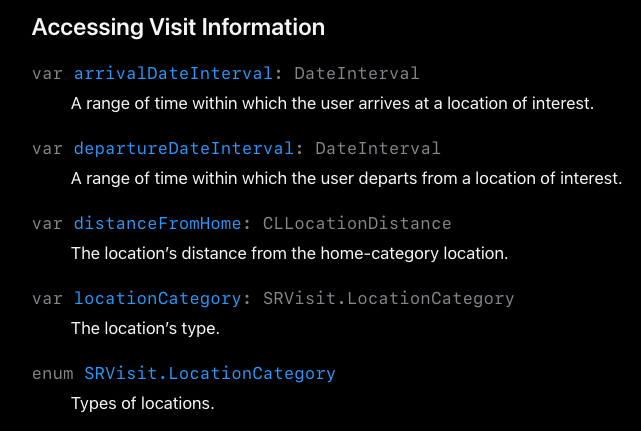

```
visits_gym_elapsedTime
visits_gym_startTime
visits_gym_distance
visits_home_elapsedTime
visits_home_startTime
visits_home_distance
visits_school_startTime
visits_school_elapsedTime
visits_school_distance
visits_unknown_startTime
visits_unknown_elapsedTime
visits_unknown_distance
visits_work_startTime
visits_work_elapsedTime
visits_work_distance
```

In [1253]:
#Create a DataFrame object
df = pd.DataFrame(
    columns = [
        'ParticipantIdentifier', 
        'datetime',
        'trial_date',
        'time',

        # visits data
        'visits_gym_elapsedTime',
        'visits_gym_startTime',
        'visits_gym_distance',
        'visits_home_elapsedTime',
        'visits_home_startTime',
        'visits_home_distance',
        'visits_school_startTime',
        'visits_school_elapsedTime',
        'visits_school_distance',
        'visits_unknown_startTime',
        'visits_unknown_elapsedTime',
        'visits_unknown_distance',
        'visits_work_startTime',
        'visits_work_elapsedTime',
        'visits_work_distance'
        
    ]
)

In [1254]:
days = [i for i in os.listdir(path) if i.startswith('RK')]
for day in tqdm(days):
    files = os.listdir(path + day)
    sensors = [i for i in files if i.startswith('sensor')]
    for sensor in sensors:
        # select for sensor
        if sensor == 'sensorkit-visits':
            participants = [i for i in os.listdir(path+day+ '/' + sensor + '/iPhone') if not i.startswith('.')] # trying to avoid .DS files
            for participant in participants:
                ParticipantIdentifier = participant
                devices = [i for i in os.listdir(path+day+ '/' + sensor+ '/iPhone/' + participant) if not i.startswith('.')]
                for device in devices:
                    data_files = os.listdir(path+day + '/' + sensor+ '/iPhone/' + participant + '/' + device)
                    for subfile in data_files:
                        filepath = path+day+ '/' + sensor + '/iPhone/' + participant + '/' + device + '/' + subfile
                        if filepath.endswith('.gz'):
                            try:
                                with gzip.open(filepath, 'r') as fin:
                                    data = json.loads(fin.read().decode('utf-8'))
                                    
                                    rows = df.shape[0]
                                    for i in range(len(data['samples'])):
                                        # dynamically creating df: https://stackoverflow.com/questions/48030350/dynamically-add-rows-to-dataframe
                                        
                                        df.loc[rows + i, 'ParticipantIdentifier'] = ParticipantIdentifier     
                                        dt = parser.parse(data['samples'][i]['sample']['arrivalDateInterval']['start']) # str -> datetime of sample
                                        df.loc[rows + i, 'datetime'] = dt
                                        df.loc[rows + i, 'trial_date'] = (dt + datetime.timedelta(hours = -4)).date() # trial day associated with sample (4am is when the day flips)
                                        df.loc[rows + i, 'time'] = dt.time()

                                        if data['samples'][i]['sample']['locationCategory'] == 'Gym':
                                            df.loc[rows + i, 'visits_gym_startTime'] = dt
                                            depart_time = parser.parse(data['samples'][i]['sample']['departureDateInterval']['start'])
                                            if depart_time != dt:
                                                df.loc[rows + i, 'visits_gym_elapsedTime'] = (depart_time - dt).total_seconds()                                                        
                                            else:
                                                df.loc[rows + i, 'visits_gym_elapsedTime'] = 7.5 * 60 # if arrive/depart are the same time                                            
                                            df.loc[rows + i, 'visits_gym_distance'] = data['samples'][i]['sample']['distanceFromHome']

                                        if data['samples'][i]['sample']['locationCategory'] == 'Home':
                                            df.loc[rows + i, 'visits_home_startTime'] = dt
                                            depart_time = parser.parse(data['samples'][i]['sample']['departureDateInterval']['start'])
                                            if depart_time != dt:
                                                df.loc[rows + i, 'visits_home_elapsedTime'] = (depart_time - dt).total_seconds()
                                                # if df.loc[rows + i, 'visits_home_elapsedTime'] > 24 * 3600:
                                                #     print(participant)
                                                #     print(day)
                                                #     print(dt)
                                                #     print(depart_time)
                                            else:
                                                df.loc[rows + i, 'visits_home_elapsedTime'] = 7.5 * 60 # if arrive/depart are the same time                                            
                                            df.loc[rows + i, 'visits_home_distance'] = data['samples'][i]['sample']['distanceFromHome']

                                        if data['samples'][i]['sample']['locationCategory'] == 'School':
                                            df.loc[rows + i, 'visits_school_startTime'] = dt
                                            depart_time = parser.parse(data['samples'][i]['sample']['departureDateInterval']['start'])
                                            if depart_time != dt:
                                                df.loc[rows + i, 'visits_school_elapsedTime'] = (depart_time - dt).total_seconds()                                         
                                            else:
                                                df.loc[rows + i, 'visits_school_elapsedTime'] = 7.5 * 60 # if arrive/depart are the same time                                            
                                            df.loc[rows + i, 'visits_school_distance'] = data['samples'][i]['sample']['distanceFromHome']

                                        if data['samples'][i]['sample']['locationCategory'] == 'Unknown':
                                            df.loc[rows + i, 'visits_unknown_startTime'] = dt
                                            depart_time = parser.parse(data['samples'][i]['sample']['departureDateInterval']['start'])
                                            if depart_time != dt:
                                                df.loc[rows + i, 'visits_unknown_elapsedTime'] = (depart_time - dt).total_seconds()                                           
                                            else:
                                                df.loc[rows + i, 'visits_unknown_elapsedTime'] = 7.5 * 60 # if arrive/depart are the same time
                                            df.loc[rows + i, 'visits_unknown_distance'] = data['samples'][i]['sample']['distanceFromHome']

                                        if data['samples'][i]['sample']['locationCategory'] == 'Work':
                                            df.loc[rows + i, 'visits_work_startTime'] = dt
                                            depart_time = parser.parse(data['samples'][i]['sample']['departureDateInterval']['start'])
                                            if depart_time != dt:
                                                df.loc[rows + i, 'visits_work_elapsedTime'] = (depart_time - dt).total_seconds()                                        
                                            else:
                                                df.loc[rows + i, 'visits_work_elapsedTime'] = 7.5 * 60 # if arrive/depart are the same time
                                            df.loc[rows + i, 'visits_work_distance'] = data['samples'][i]['sample']['distanceFromHome']
                                            
                            except (OSError, ValueError) as e:  
                                pass

# save to csv
df.to_csv('../3_3_2_processed_data/run1_sk_visits.csv', index=False)

100%|██████████████████████████████████████████████████████████████████| 22/22 [00:06<00:00,  3.47it/s]


## Survey Results

In [1327]:
#Create a DataFrame object
df = pd.DataFrame(
    columns = [
        'ParticipantIdentifier', 
        'ResultIdentifier',
        'Answers'
    ]
)

In [1328]:
days = [i for i in os.listdir(path) if i.startswith('RK')]
for day in tqdm(days):
    files = os.listdir(path + day)
    results = [i for i in files if i.startswith('SurveyQuestionResults')]
    for result in results:
        filepath = path+day+ '/' + result
        temp_df = pd.read_csv(filepath)
        
        df = pd.concat([df, temp_df], ignore_index=True)


# add trial day column 
df = df.dropna(subset=['EndDate']) # drop any NAs
df = df.reset_index(drop=True)
df['trial_date'] = None        

for i in range(df.shape[0]):
    dt = parser.parse(df.EndDate[i])
    df.loc[i, 'trial_date'] = (dt + datetime.timedelta(hours = -4)).date() # trial day associated with sample (4am is when the day flips)

# save to csv
df.to_csv('../3_3_2_processed_data/run1_survey_results.csv', index=False)

100%|██████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 24.70it/s]


In [962]:
filepath = '../3_3_1_raw_data/testing/run1_check_adherence/RK.8D1DBFAD.DJWThesis_20221005-20221006/sensorkit-visits/iPhone/1e7aef96-16cc-43f8-95d4-e3bc582eb6d3/2017C676-C22A-4318-903C-7544760252BB/2022-10-03T060055-0400_2022-10-03T060055-0400.json.gz'

In [733]:
path = '../3_3_1_raw_data/testing/run1_check_adherence/'

In [963]:
with gzip.open(filepath, 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))

# Aggregate

## Device Usage

### Unlocks

In [1426]:
df = pd.read_csv('../3_3_2_processed_data/run1_sk_deviceUsage.csv')

In [1477]:
df

,Unnamed: 0,ParticipantIdentifier,datetime,trial_date,time,duration,total_unlocks,total_unlock_duration,app_usage_books,app_usage_business,...,web_usage_reference,web_usage_shopping,web_usage_social_networking,web_usage_sports,web_usage_stickers,web_usage_travel,web_usage_utilities,web_usage_weather,app_usage_social_network,web_usage_utilities_miscellaneous
0,0,5e509967-0d3b-4fe1-a275-231ba42473d5,2022-10-09 05:00:00-04:00,2022-10-09,05:00:00,900,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5e509967-0d3b-4fe1-a275-231ba42473d5,2022-10-09 05:15:00-04:00,2022-10-09,05:15:00,900,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5e509967-0d3b-4fe1-a275-231ba42473d5,2022-10-09 05:30:00-04:00,2022-10-09,05:30:00,900,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,5e509967-0d3b-4fe1-a275-231ba42473d5,2022-10-09 05:45:00-04:00,2022-10-09,05:45:00,900,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5e509967-0d3b-4fe1-a275-231ba42473d5,2022-10-09 06:00:00-04:00,2022-10-09,06:00:00,900,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131059,131059,92863208-10a4-443b-a225-18630552f5cc,2022-10-15 01:00:00-04:00,2022-10-14,01:00:00,900,0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
131060,131060,92863208-10a4-443b-a225-18630552f5cc,2022-10-15 01:15:00-04:00,2022-10-14,01:15:00,900,0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131061,131061,92863208-10a4-443b-a225-18630552f5cc,2022-10-15 01:30:00-04:00,2022-10-14,01:30:00,900,3,226.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131062,131062,92863208-10a4-443b-a225-18630552f5cc,2022-10-15 01:45:00-04:00,2022-10-14,01:45:00,900,3,223.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1478]:
subs = np.random.choice(np.unique(df.ParticipantIdentifier), 10)

In [1479]:
plot = df[df['ParticipantIdentifier'].isin(subs)]

In [1480]:
x = plot.groupby(['ParticipantIdentifier', 'trial_date'])['total_unlocks'].sum().reset_index(name = 'total_unlocks')

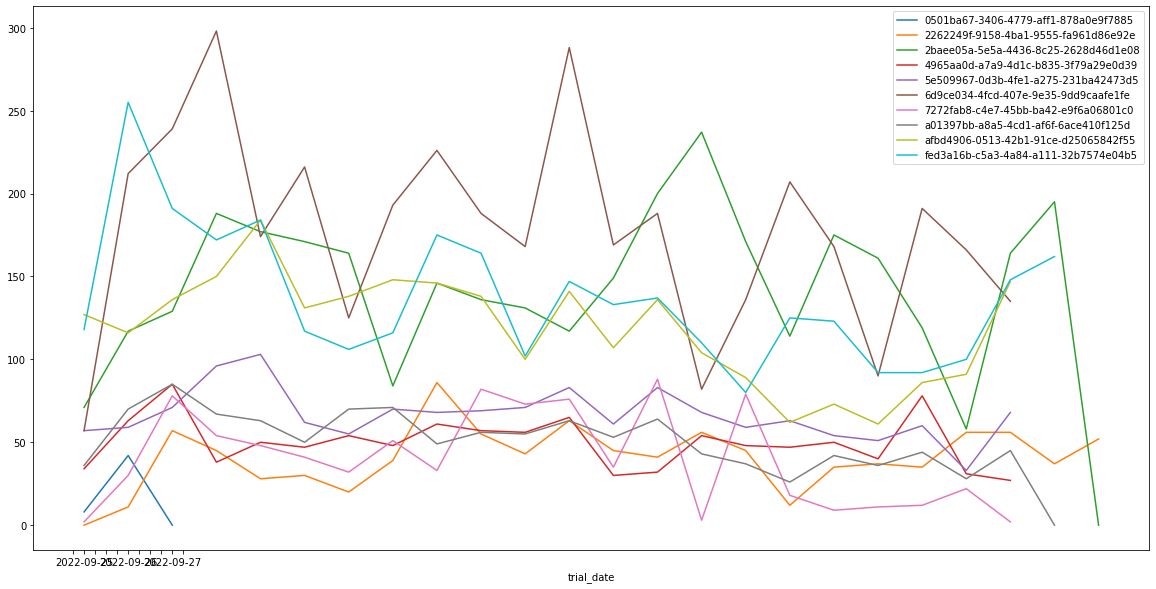

In [1481]:
x.set_index('trial_date', inplace = True)
x.groupby('ParticipantIdentifier')['total_unlocks'].plot(legend=True, figsize=(20, 10));

In [1482]:
x = plot.groupby(['ParticipantIdentifier', 'trial_date'])['total_unlock_duration'].sum().reset_index(name = 'unlock_duration')
x.unlock_duration = x.unlock_duration/3600

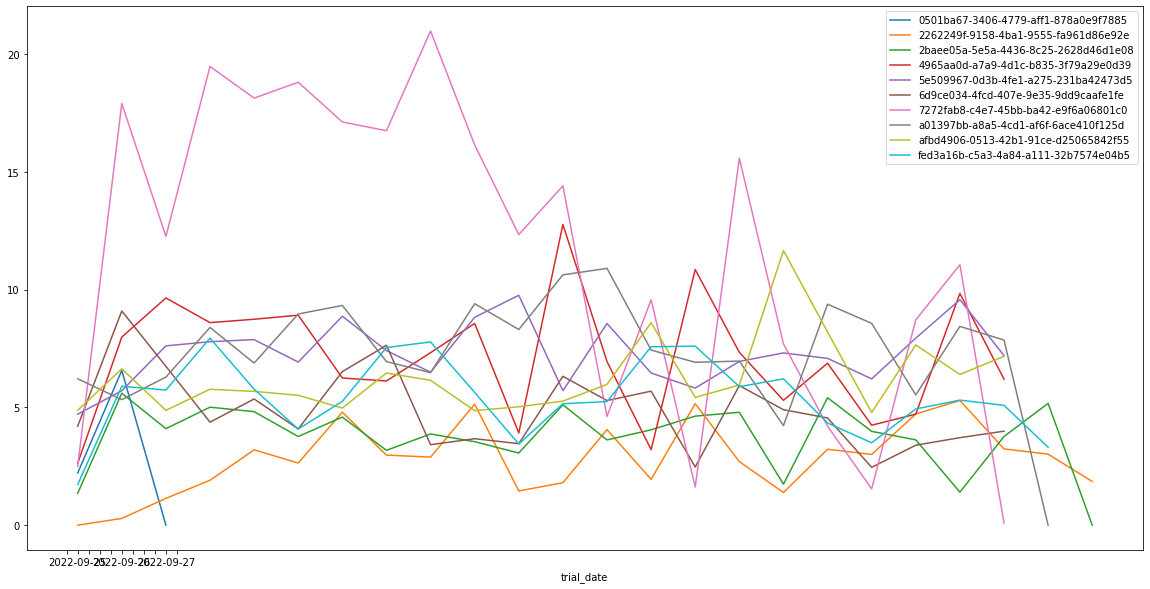

In [1483]:
x.set_index('trial_date', inplace = True)
x.groupby('ParticipantIdentifier')['unlock_duration'].plot(legend=True, figsize=(20, 10));

### Social Media

In [1473]:
df = pd.read_csv('../3_3_2_processed_data/run1_sk_deviceUsage.csv')

In [1476]:
df.app_usage_photo_and_video.describe()

count    29127.000000
mean       304.258729
std        316.588070
min          0.000000
25%         49.000000
50%        167.000000
75%        502.500000
max       1800.000000
Name: app_usage_photo_and_video, dtype: float64

In [1456]:
social = df.groupby(['ParticipantIdentifier', 'trial_date'])['web_usage_social_networking'].sum().reset_index(name = 'social_time')

In [1455]:
x.social_time.describe()

count     1459.000000
mean        74.409184
std        548.996883
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      10486.000000
Name: social_time, dtype: float64

In [1461]:
social = df.groupby(['ParticipantIdentifier', 'trial_date'])['app_usage_social_network'].sum().reset_index(name = 'social_time')

In [1462]:
social = df.groupby(['ParticipantIdentifier', 'trial_date']).agg(
    social_time_app = ('app_usage_social_network','sum'),
    social_time_web = ('web_usage_social_networking','sum'),
).reset_index()

In [1463]:
social['social_time'] = social.social_time_app + social.social_time_web

In [1464]:
df = pd.read_csv('../3_3_2_processed_data/run1_survey_results.csv')

In [1465]:
affect_df = df.loc[df.ResultIdentifier.str.startswith('affect'), ['ParticipantIdentifier', 'ResultIdentifier', 'Answers', 'trial_date']]

In [1466]:
affect_df = affect_df[~affect_df.ResultIdentifier.str.endswith('_am')].reset_index(drop=True)

In [1467]:
cor_df = social.merge(affect_df, how='left', on=['ParticipantIdentifier', 'trial_date'])

In [1468]:
cor_df.head()

,ParticipantIdentifier,trial_date,social_time_app,social_time_web,social_time,ResultIdentifier,Answers
0,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-09-29,100.0,0.0,100.0,NaN,NaN
1,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-09-30,652.0,0.0,652.0,affect_neg_frustrated,3
2,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-09-30,652.0,0.0,652.0,affect_pos_relaxedCalm,2
3,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-09-30,652.0,0.0,652.0,affect_neg_ashamed,1
4,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-09-30,652.0,0.0,652.0,affect_pos_excited,4


In [1469]:
cor_df.Answers = pd.to_numeric(cor_df.Answers)

In [1470]:
print(f'Max: {round(cor_df.social_time.max()/3600,2)} hours')

Max: 10.96 hours


In [1471]:
cor_df.social_time.describe()

count    21298.000000
mean      1178.048831
std       2682.901360
min          0.000000
25%         18.000000
50%        284.000000
75%       1172.000000
max      39461.000000
Name: social_time, dtype: float64

In [1472]:
# Stress and Words typed
data = cor_df.loc[cor_df.ResultIdentifier=='affect_neg_stressed']

md = smf.mixedlm("Answers ~ social_time", data, groups=data["ParticipantIdentifier"])
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Answers   
No. Observations: 1044    Method:             REML      
No. Groups:       65      Scale:              1.0146    
Min. group size:  2       Log-Likelihood:     -1571.0953
Max. group size:  22      Converged:          Yes       
Mean group size:  16.1                                  
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      3.316    0.102 32.664 0.000  3.117  3.515
social_time    0.000    0.000  1.334 0.182 -0.000  0.000
Group Var      0.564    0.118                           



## Keyboard

In [1394]:
df = pd.read_csv('../3_3_2_processed_data/run1_sk_keyboard.csv')

In [1395]:
df.set_index('trial_date', inplace=True)

In [1396]:
subs = np.random.choice(np.unique(df.ParticipantIdentifier), 20)

In [1397]:
plot = df[df['ParticipantIdentifier'].isin(subs)]

In [1398]:
x = plot.groupby(['ParticipantIdentifier', 'trial_date'])['keyboard_total_words'].sum().reset_index(name = 'word_count')

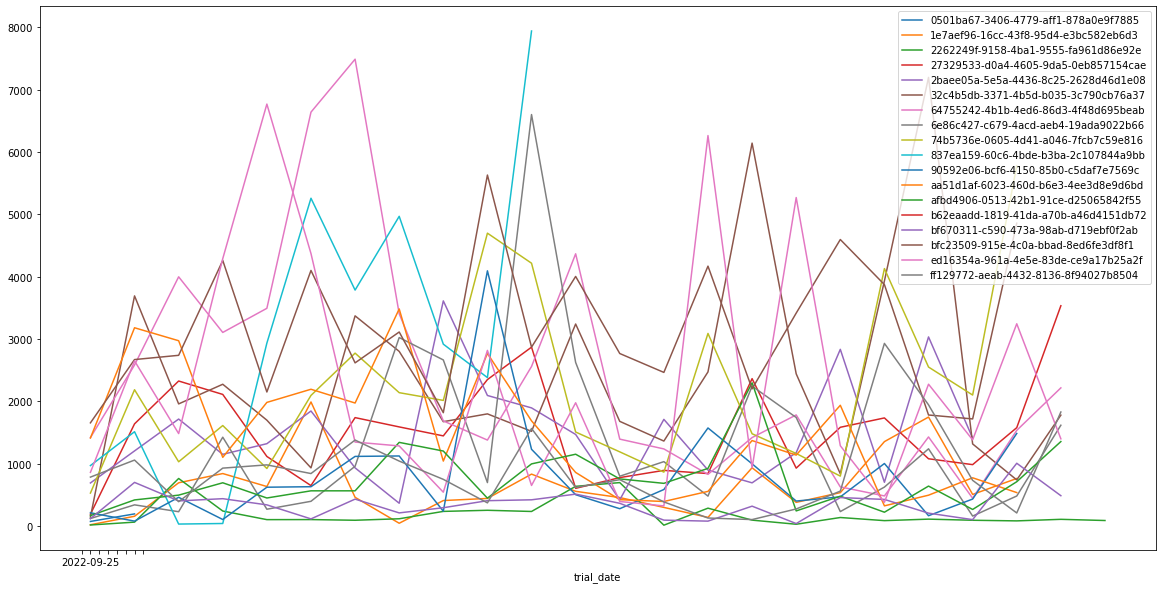

In [1399]:
x.set_index('trial_date', inplace = True)
x.groupby('ParticipantIdentifier')['word_count'].plot(legend=True, figsize=(20, 10));

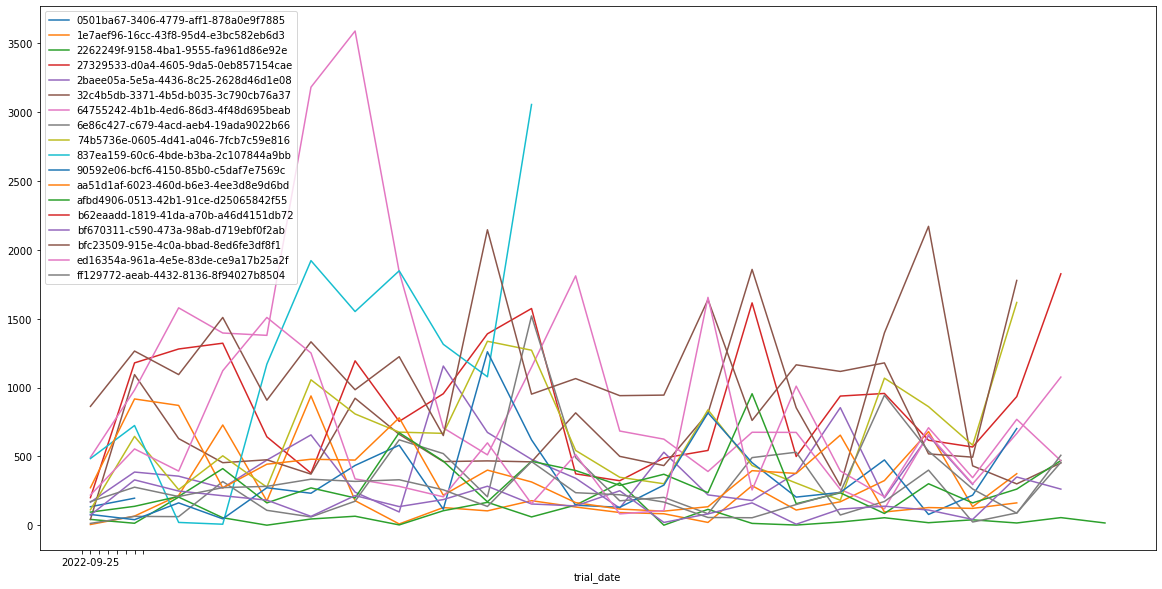

In [1400]:
y = plot.groupby(['ParticipantIdentifier', 'trial_date'])['keyboard_total_deletes'].sum().reset_index(name = 'delete_count')
y.set_index('trial_date', inplace = True)
y.groupby('ParticipantIdentifier')['delete_count'].plot(legend=True, figsize=(20, 10));

In [1401]:
x['ratio'] = y.delete_count / x.word_count

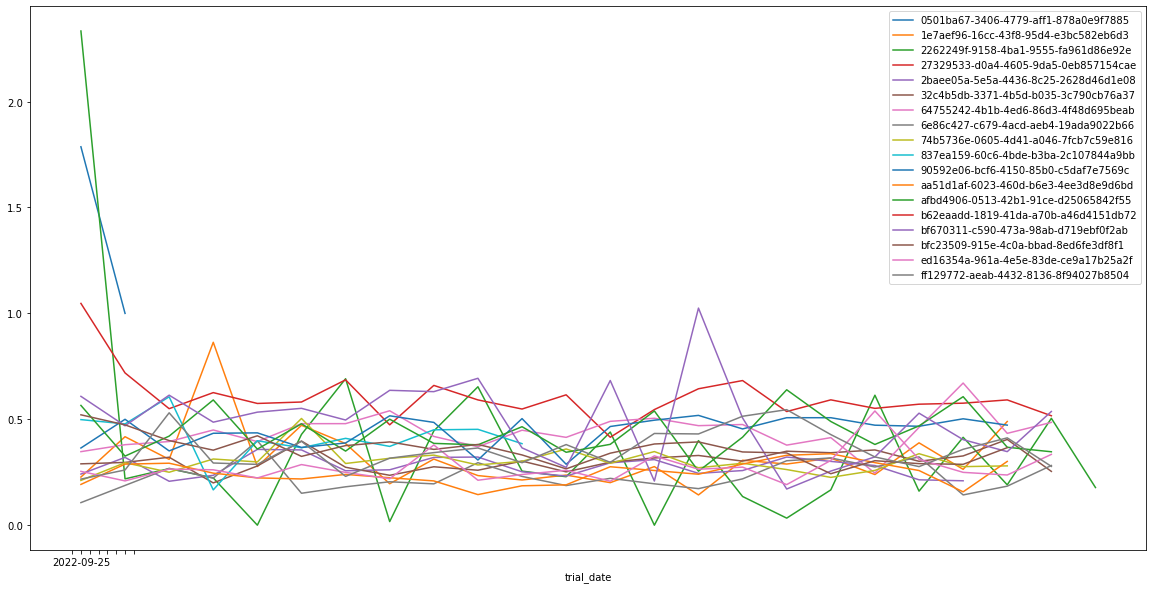

In [1402]:
x.groupby('ParticipantIdentifier')['ratio'].plot(legend=True, figsize=(20, 10));

In [1403]:
del_ratio = x.reset_index()

### Typing and Affect

Is a higher delete ratio correlated with higher stress?

In [1329]:
df = pd.read_csv('../3_3_2_processed_data/run1_survey_results.csv')

In [1330]:
df.shape

(236041, 9)

In [1344]:
affect_df = df.loc[df.ResultIdentifier.str.startswith('affect'), ['ParticipantIdentifier', 'ResultIdentifier', 'Answers', 'trial_date']]

In [1345]:
affect_df = affect_df[~affect_df.ResultIdentifier.str.endswith('_am')].reset_index(drop=True)

In [1393]:
affect_df.head(5)

,ParticipantIdentifier,ResultIdentifier,Answers,trial_date
0,a01397bb-a8a5-4cd1-af6f-6ace410f125d,affect_neg_frustrated,5,2022-10-11
1,a01397bb-a8a5-4cd1-af6f-6ace410f125d,affect_pos_relaxedCalm,2,2022-10-11
2,a01397bb-a8a5-4cd1-af6f-6ace410f125d,affect_neg_ashamed,5,2022-10-11
3,a01397bb-a8a5-4cd1-af6f-6ace410f125d,affect_pos_excited,2,2022-10-11
4,a01397bb-a8a5-4cd1-af6f-6ace410f125d,affect_neg_stressed,5,2022-10-11


In [1387]:
cor_df = del_ratio.merge(affect_df, how='left', on=['ParticipantIdentifier', 'trial_date'])

In [1388]:
cor_df.Answers = pd.to_numeric(cor_df.Answers)

In [1365]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [1389]:
# Stress and Words typed
data = cor_df.loc[cor_df.ResultIdentifier=='affect_neg_stressed']

md = smf.mixedlm("word_count ~ Answers", data, groups=data["ParticipantIdentifier"])
mdf = md.fit()
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: word_count  
No. Observations:  502     Method:             REML        
No. Groups:        34      Scale:              1870222.7793
Min. group size:   2       Log-Likelihood:     -4364.8463  
Max. group size:   22      Converged:          Yes         
Mean group size:   14.8                                    
-----------------------------------------------------------
             Coef.    Std.Err.   z   P>|z|  [0.025  0.975] 
-----------------------------------------------------------
Intercept     822.916  304.047 2.707 0.007 226.995 1418.838
Answers       206.816   63.379 3.263 0.001  82.596  331.036
Group Var 1402381.879  293.419                             



In [1405]:
# Stress and delete ratio
data = cor_df.loc[cor_df.ResultIdentifier=='affect_neg_stressed']

md = smf.mixedlm("ratio ~ Answers", data, groups=data["ParticipantIdentifier"])
mdf = md.fit()
print(mdf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ratio   
No. Observations: 502     Method:             REML    
No. Groups:       34      Scale:              0.0145  
Min. group size:  2       Log-Likelihood:     301.6903
Max. group size:  22      Converged:          Yes     
Mean group size:  14.8                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.386    0.028 13.828 0.000  0.331  0.441
Answers     -0.004    0.006 -0.790 0.430 -0.016  0.007
Group Var    0.013    0.030                           



In [1392]:
# Happiness and words typed
data = cor_df.loc[cor_df.ResultIdentifier=='affect_pos_happy']

md = smf.mixedlm("word_count ~ Answers", data, groups=data["ParticipantIdentifier"])
mdf = md.fit()
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  word_count  
No. Observations:  502      Method:              REML        
No. Groups:        34       Scale:               1867380.2949
Min. group size:   2        Log-Likelihood:      -4363.6086  
Max. group size:   22       Converged:           Yes         
Mean group size:   14.8                                      
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    2283.896  298.305  7.656 0.000 1699.228 2868.564
Answers      -243.266   67.329 -3.613 0.000 -375.228 -111.304
Group Var 1325740.343  278.924                               



In [1406]:
# Happiness and words typed
data = cor_df.loc[cor_df.ResultIdentifier=='affect_pos_happy']

md = smf.mixedlm("word_count ~ ratio", data, groups=data["ParticipantIdentifier"])
mdf = md.fit()
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  word_count  
No. Observations:   502      Method:              REML        
No. Groups:         34       Scale:               1915333.0356
Min. group size:    2        Log-Likelihood:      -4367.8594  
Max. group size:    22       Converged:           Yes         
Mean group size:    14.8                                      
--------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------
Intercept    1635.917  286.757  5.705 0.000  1073.883 2197.951
ratio        -308.570  515.122 -0.599 0.549 -1318.191  701.052
Group Var 1352721.397  283.162                                



## Visits

In [1083]:
df = pd.read_csv('../3_3_2_processed_data/run1_sk_visits.csv')

In [1084]:
df.set_index('trial_date', inplace=True)

In [1114]:
subs = np.random.choice(np.unique(df.ParticipantIdentifier), 20)

In [1130]:
plot = df[df['ParticipantIdentifier'].isin(subs)]

In [1131]:
plot.shape

(2008, 18)

### Work Hours

In [1132]:
plot['work_hours'] = plot.visits_work_elapsedTime/3600

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_78256/3475976843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot['work_hours'] = plot.visits_work_elapsedTime/3600


In [1133]:
plot = plot.drop_duplicates()

In [1134]:
x = plot.groupby(['ParticipantIdentifier', 'trial_date'])['work_hours'].sum().reset_index(name = 'time_work')

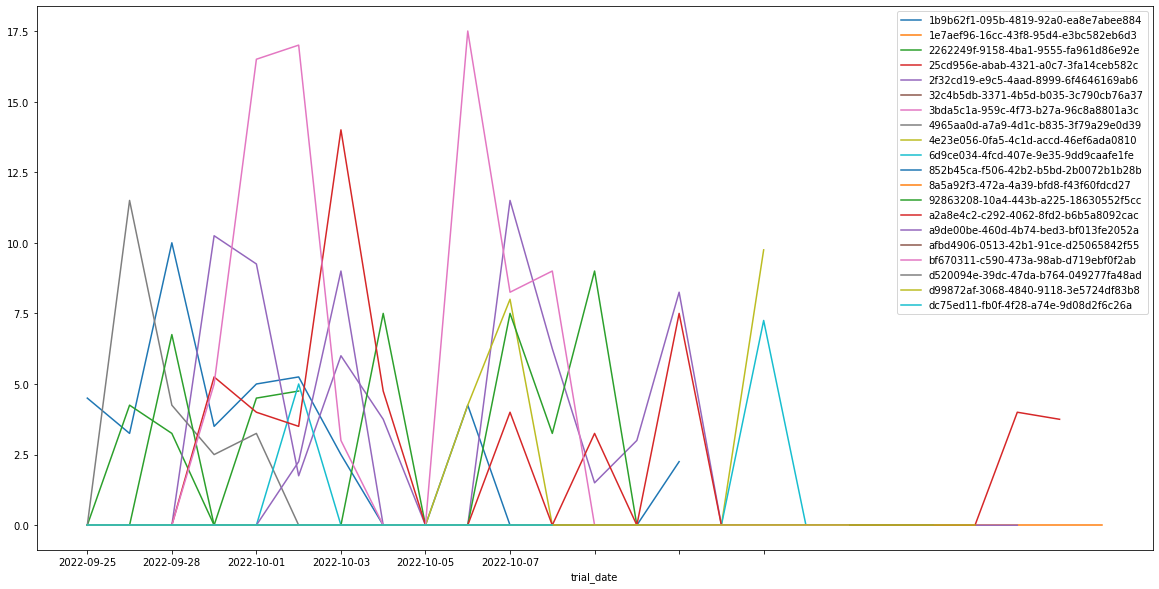

In [1135]:
x.set_index('trial_date', inplace = True)
x.groupby('ParticipantIdentifier')['time_work'].plot(legend=True, figsize=(20, 10));

### Work Distance

In [1165]:
x = df[['ParticipantIdentifier', 'visits_work_distance']].dropna().drop_duplicates(subset=['ParticipantIdentifier']).reset_index(drop=True)

In [1172]:
x = x.loc[x.visits_work_distance<100000]
x.visits_work_distance = x.visits_work_distance/1000

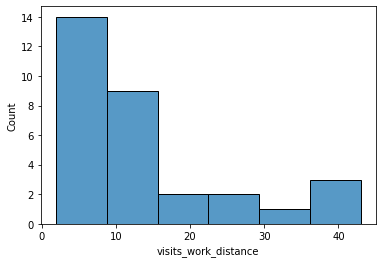

In [1174]:
sns.histplot(data = x, x = 'visits_work_distance');

---
Pretty straightforward to do calculations of un-nested keys...

- totalUnlocks
- totalUnlockDuration
- totalScreenWakes

In [ ]:
result_tuple = tuple(jsonnn_tree.execute('$..totalUnlocks')) 
totalUnlocks = sum(result_tuple)
print(f'Total unlocks = {totalUnlocks}\n{round(totalUnlocks/hours, 2)} unlocks per hour...')

Total unlocks = 127
9.07 unlocks per hour...


In [ ]:
result_tuple = tuple(jsonnn_tree.execute('$..totalUnlockDuration')) 
totalUnlockDuration = sum(result_tuple)/3600
print(f'Unlocked time = {round(totalUnlockDuration,2)} hours\n{(round(totalUnlockDuration/hours,2)) * 100}% of the time period')

Unlocked time = 5.1 hours
36.0% of the time period


In [ ]:
result_tuple = tuple(jsonnn_tree.execute('$..totalScreenWakes')) 
totalScreenWakes = sum(result_tuple)
print(f'Total Screen wakes = {totalScreenWakes}\n{round(totalScreenWakes/hours, 2)} screen wakes per hour')

Total Screen wakes = 320
22.86 screen wakes per hour
